# Data Ingestion & Preliminary Analysis

In [1]:
import re
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
import emoji
sns.set(style="whitegrid")
%matplotlib inline

def load_reviews(data_dir, sentiment_label):
    """
    Loads all text files from a directory and assigns a sentiment label.

    Args:
        data_dir (str): Path to the directory containing text files.
        sentiment_label (str): Label to assign to all loaded reviews.

    Returns:
        List[str]: List of review texts.
    """
    reviews = []
    # List all files in the directory
    file_names = os.listdir(data_dir)
    file_names = sorted(file_names)  # Sorting to maintain a consistent order
    for file_name in file_names:
        file_path = os.path.join(data_dir, file_name)
        # Read each file assuming UTF-8 encoding
        with open(file_path, 'r', encoding='utf-8') as f:
            review_text = f.read().strip()
            reviews.append(review_text)
    return reviews


pos_dir = 'data/pos'
neg_dir = 'data/neg'

if not os.path.exists(pos_dir) or not os.path.exists(neg_dir):
    raise FileNotFoundError(
        "One or both of the data directories 'data/pos' or 'data/neg' do not exist.")

# Load reviews and assign labels
positive_reviews = load_reviews(pos_dir, 'positive')
negative_reviews = load_reviews(neg_dir, 'negative')

# Create DataFrames for positive and negative reviews
df_pos = pd.DataFrame(
    {'review_text': positive_reviews, 'sentiment': 'positive'})
df_neg = pd.DataFrame(
    {'review_text': negative_reviews, 'sentiment': 'negative'})

# Combine the two DataFrames into one
df = pd.concat([df_pos, df_neg], ignore_index=True)

# Shuffle the dataset for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print basic dataset statistics
print("Total reviews:", df.shape[0])
print("Positive reviews:", df[df['sentiment'] == 'positive'].shape[0])
print("Negative reviews:", df[df['sentiment'] == 'negative'].shape[0])
df.head()


Total reviews: 50000
Positive reviews: 25000
Negative reviews: 25000


,review_text,sentiment
0,I can't say much about this film. I think it s...,negative
1,After the initial shock of realizing the guts ...,positive
2,Seven Ups has been compared to Bullitt for the...,positive
3,There is a scene in Dan in Real Life where the...,positive
4,I wouldn't say this is a *bad* movie. Unfortun...,negative


# Exploratory Data Analysis (EDA) on Raw Reviews

In [2]:
stop_words = set(stopwords.words('english'))

def word_count(text):
    """Returns the number of words in a text."""
    return len(text.split())

def count_punctuations(text):
    """Counts punctuation characters in the text."""
    return sum(1 for c in text if c in string.punctuation)

def count_urls(text):
    """Counts URLs in the text using a regex pattern."""
    pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return len(re.findall(pattern, text))

def count_stopwords(text):
    """Counts the number of stopwords in the text."""
    tokens = text.split()
    return sum(1 for token in tokens if token.lower() in stop_words)

def display_wordcloud(text_data, title):
    """Generates and displays a word cloud from text data."""
    text = " ".join(text_data)
    wc = WordCloud(background_color="white",
                   stopwords=STOPWORDS,
                   max_words=200,
                   max_font_size=100,
                   random_state=42)
    wc.generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

def get_top_ngrams(corpus, n, top_k=20):
    """
    Computes top n-grams (excluding stopwords) for the given corpus.
    Returns a list of tuples (n-gram as string, count).
    """
    ngram_counter = Counter()
    for text in corpus:
        # Filter tokens: convert to lowercase and skip stopwords
        tokens = [word.lower() for word in text.split() if word.lower() not in stop_words]
        n_grams = list(ngrams(tokens, n))
        ngram_counter.update(n_grams)
    # Convert ngram tuples to strings
    top_ngrams = [( " ".join(ngram), count ) for ngram, count in ngram_counter.most_common(top_k)]
    return top_ngrams

In [3]:
# --- Compute and Append Basic Metrics ---
df['word_count'] = df['review_text'].apply(word_count)
df['punct_count'] = df['review_text'].apply(count_punctuations)
df['url_count'] = df['review_text'].apply(count_urls)
df['stopword_count'] = df['review_text'].apply(count_stopwords)

# --- Separate DataFrames by Sentiment ---
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']


Word Count Statistics (Overall):
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


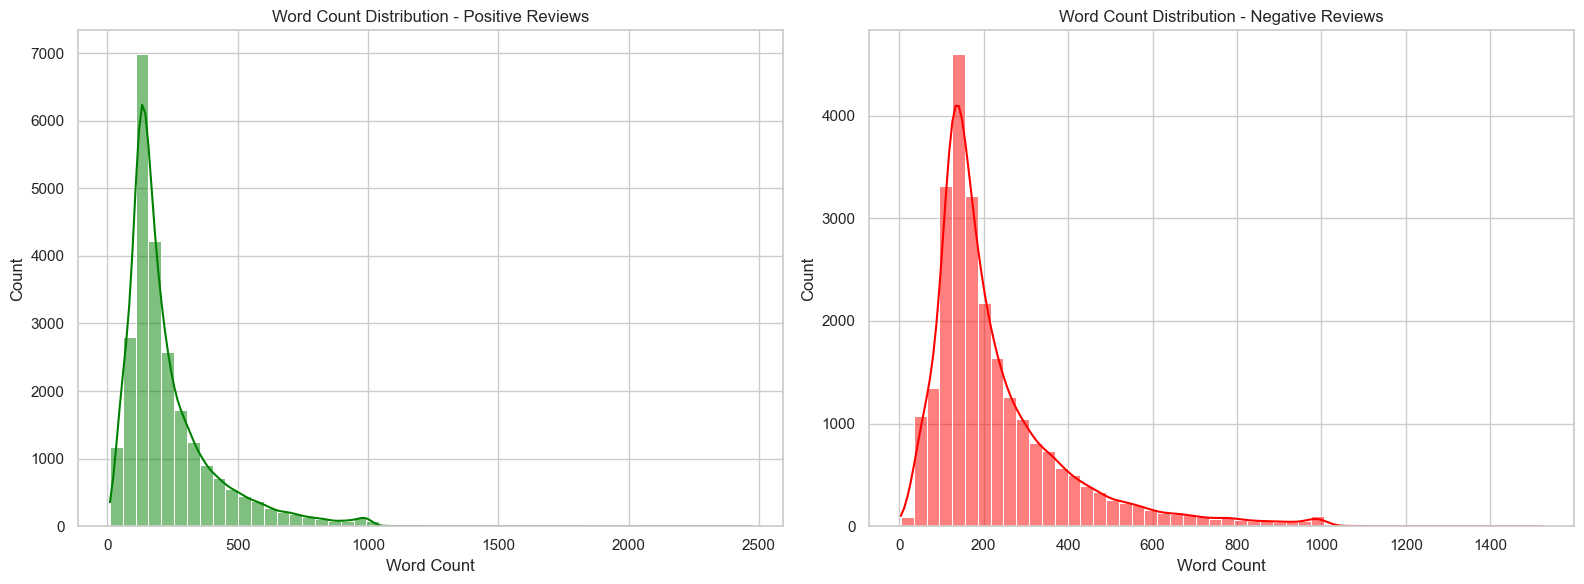

In [4]:
# --- Word Count Analysis ---
print("\nWord Count Statistics (Overall):")
print(df['word_count'].describe())

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(df_pos['word_count'], bins=50, kde=True, color='green', ax=axes[0])
axes[0].set_title("Word Count Distribution - Positive Reviews")
axes[0].set_xlabel("Word Count")
sns.histplot(df_neg['word_count'], bins=50, kde=True, color='red', ax=axes[1])
axes[1].set_title("Word Count Distribution - Negative Reviews")
axes[1].set_xlabel("Word Count")
plt.tight_layout()
plt.show()


Punctuation Count Statistics (Overall):
count    50000.000000
mean        52.578560
std         43.922545
min          0.000000
25%         24.000000
50%         39.000000
75%         67.000000
max        657.000000
Name: punct_count, dtype: float64


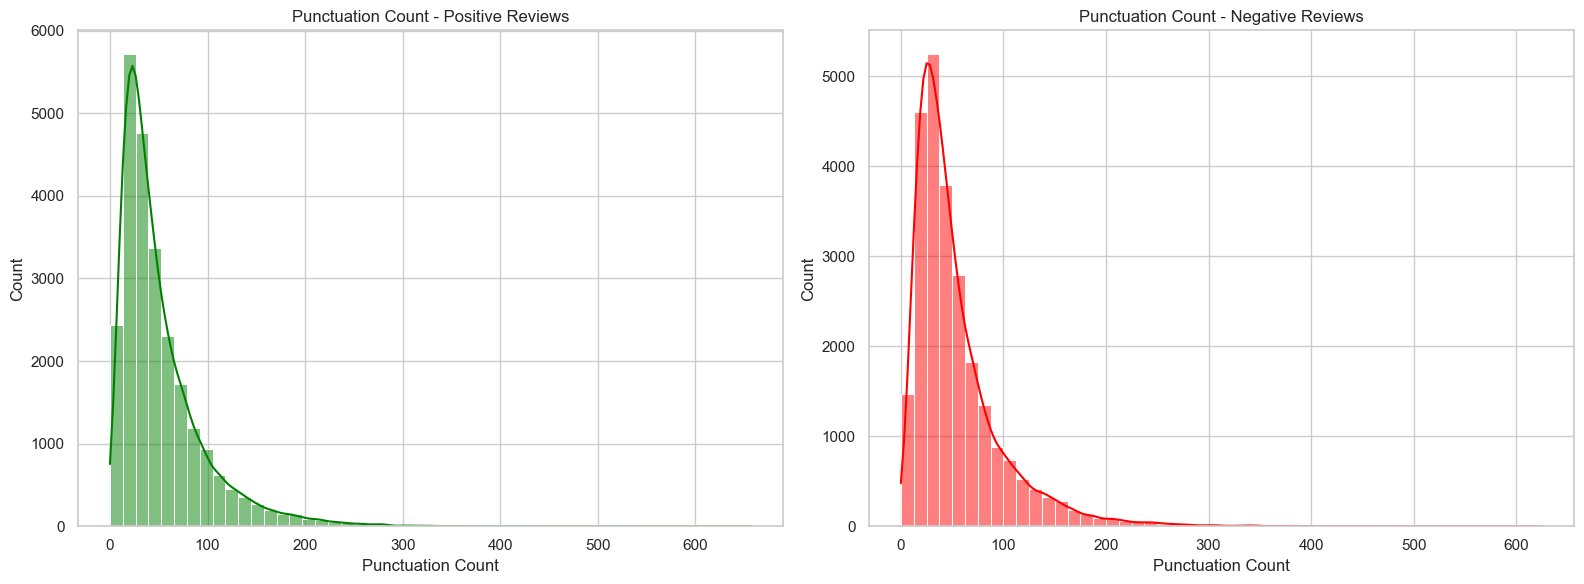

In [5]:
# --- Punctuation Count Analysis ---
print("\nPunctuation Count Statistics (Overall):")
print(df['punct_count'].describe())

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(df_pos['punct_count'], bins=50, kde=True, color='green', ax=axes[0])
axes[0].set_title("Punctuation Count - Positive Reviews")
axes[0].set_xlabel("Punctuation Count")
sns.histplot(df_neg['punct_count'], bins=50, kde=True, color='red', ax=axes[1])
axes[1].set_title("Punctuation Count - Negative Reviews")
axes[1].set_xlabel("Punctuation Count")
plt.tight_layout()
plt.show()


URL Count Statistics (Overall):
count    50000.000000
mean         0.002540
std          0.054163
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: url_count, dtype: float64


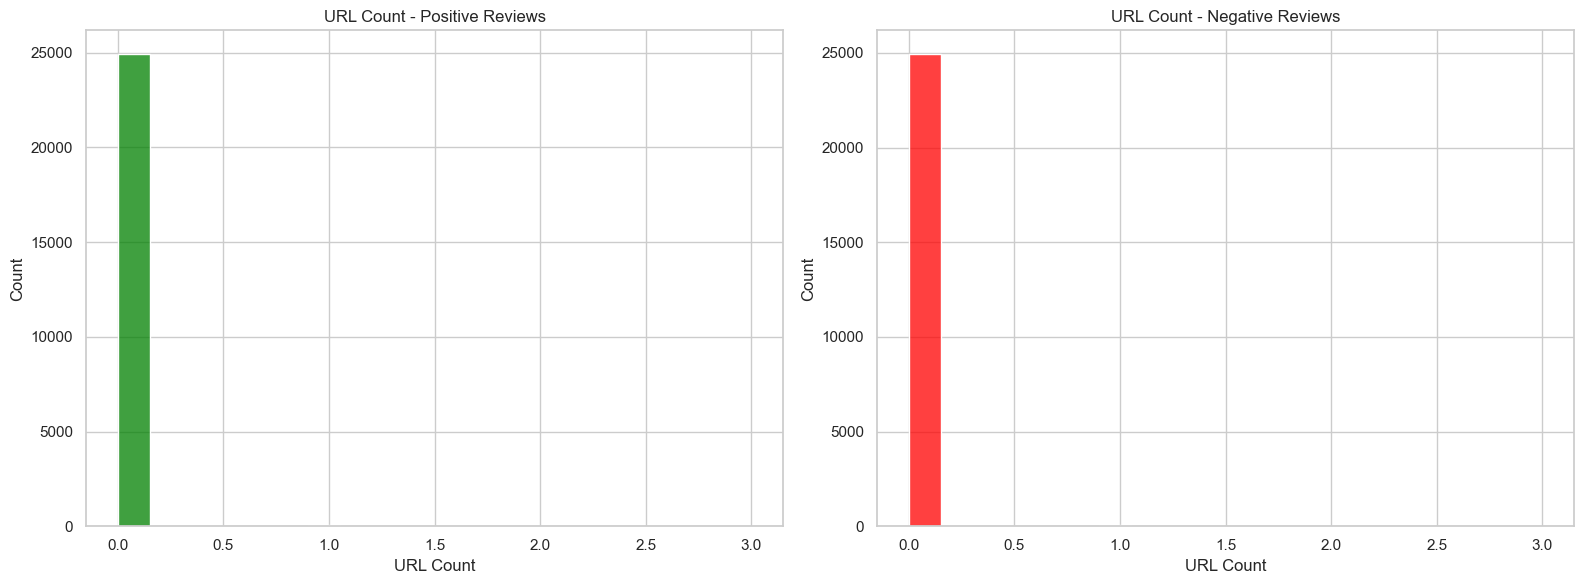

In [6]:
# --- URL Count Analysis ---
print("\nURL Count Statistics (Overall):")
print(df['url_count'].describe())

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(df_pos['url_count'], bins=20, kde=False, color='green', ax=axes[0])
axes[0].set_title("URL Count - Positive Reviews")
axes[0].set_xlabel("URL Count")
sns.histplot(df_neg['url_count'], bins=20, kde=False, color='red', ax=axes[1])
axes[1].set_title("URL Count - Negative Reviews")
axes[1].set_xlabel("URL Count")
plt.tight_layout()
plt.show()


Stopword Count Statistics (Overall):
count    50000.000000
mean       104.454840
std         77.288741
min          0.000000
25%         57.000000
50%         80.000000
75%        126.000000
max       1061.000000
Name: stopword_count, dtype: float64


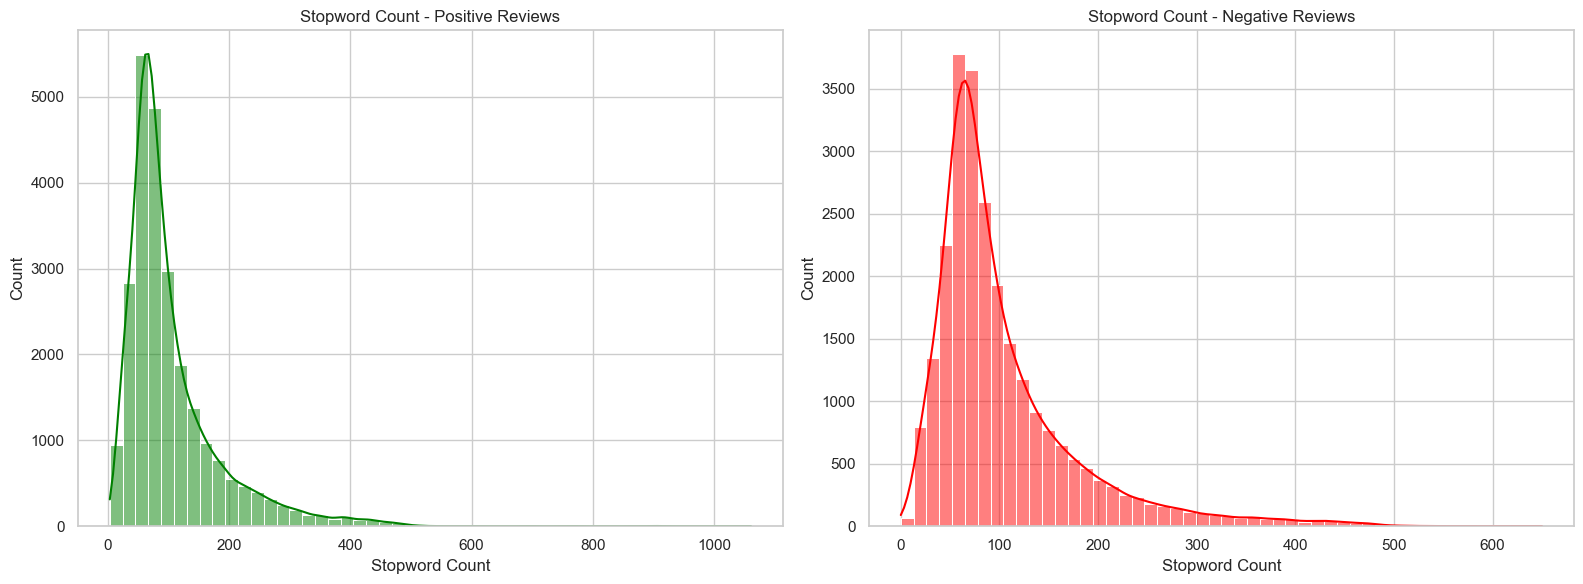

In [7]:
# --- Stopword Count Analysis ---
print("\nStopword Count Statistics (Overall):")
print(df['stopword_count'].describe())

fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(df_pos['stopword_count'], bins=50, kde=True, color='green', ax=axes[0])
axes[0].set_title("Stopword Count - Positive Reviews")
axes[0].set_xlabel("Stopword Count")
sns.histplot(df_neg['stopword_count'], bins=50, kde=True, color='red', ax=axes[1])
axes[1].set_title("Stopword Count - Negative Reviews")
axes[1].set_xlabel("Stopword Count")
plt.tight_layout()
plt.show()

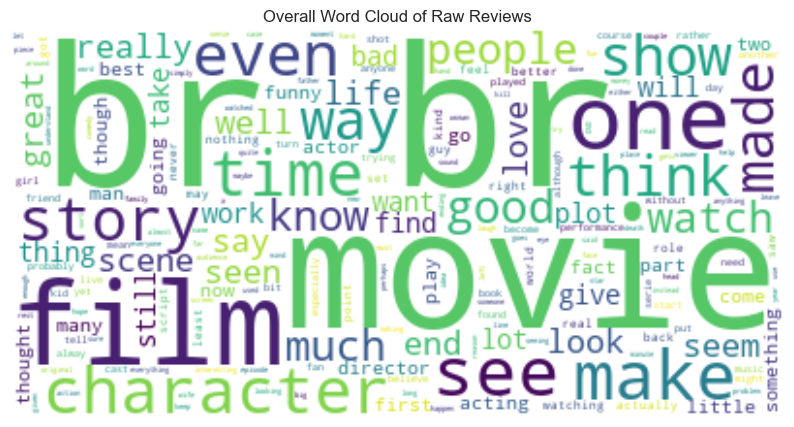

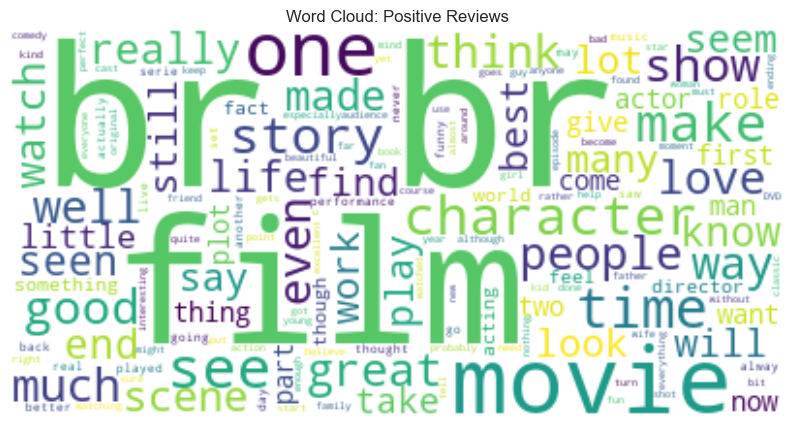

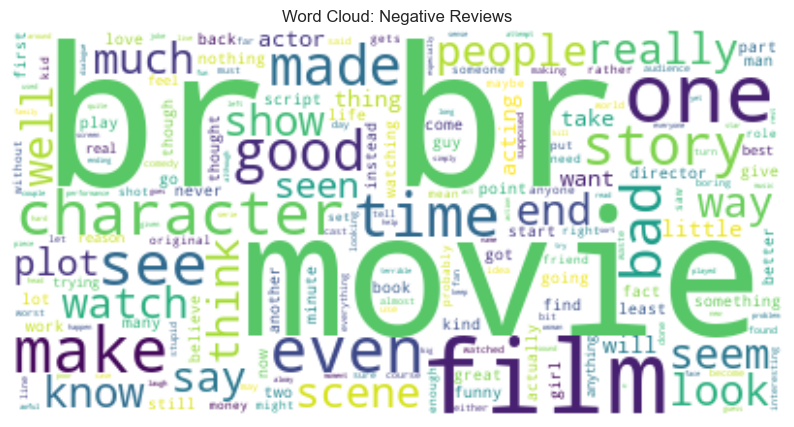

In [8]:
# --- WordCloud Visualizations ---
display_wordcloud(df['review_text'], "Overall Word Cloud of Raw Reviews")
display_wordcloud(df_pos['review_text'], "Word Cloud: Positive Reviews")
display_wordcloud(df_neg['review_text'], "Word Cloud: Negative Reviews")

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/2285613859.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="bigram", data=bigrams_pos_df, palette="viridis")


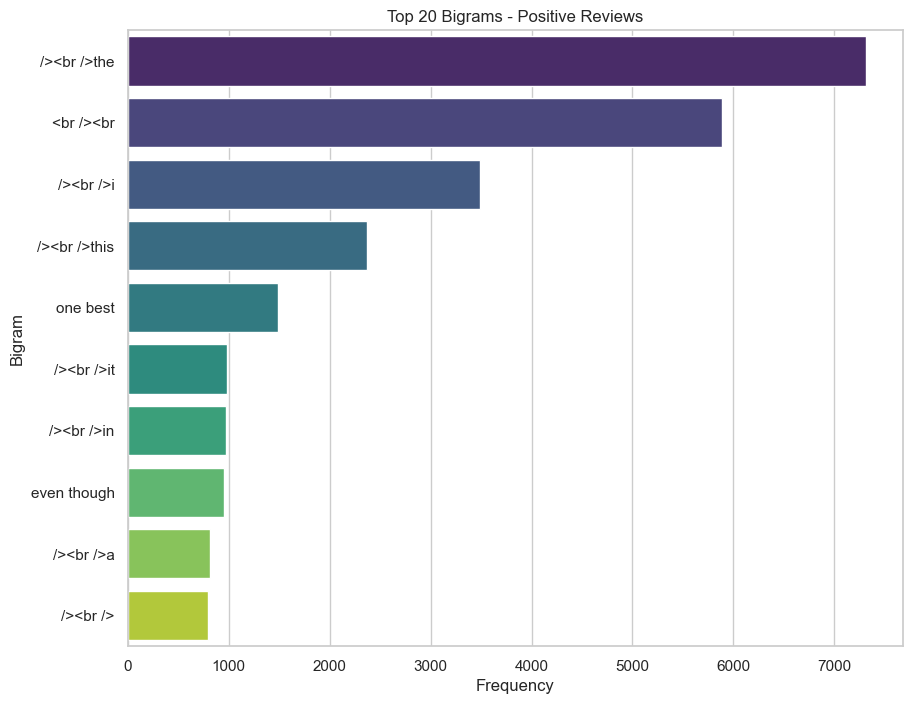

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/2285613859.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="trigram", data=trigrams_pos_df, palette="magma")


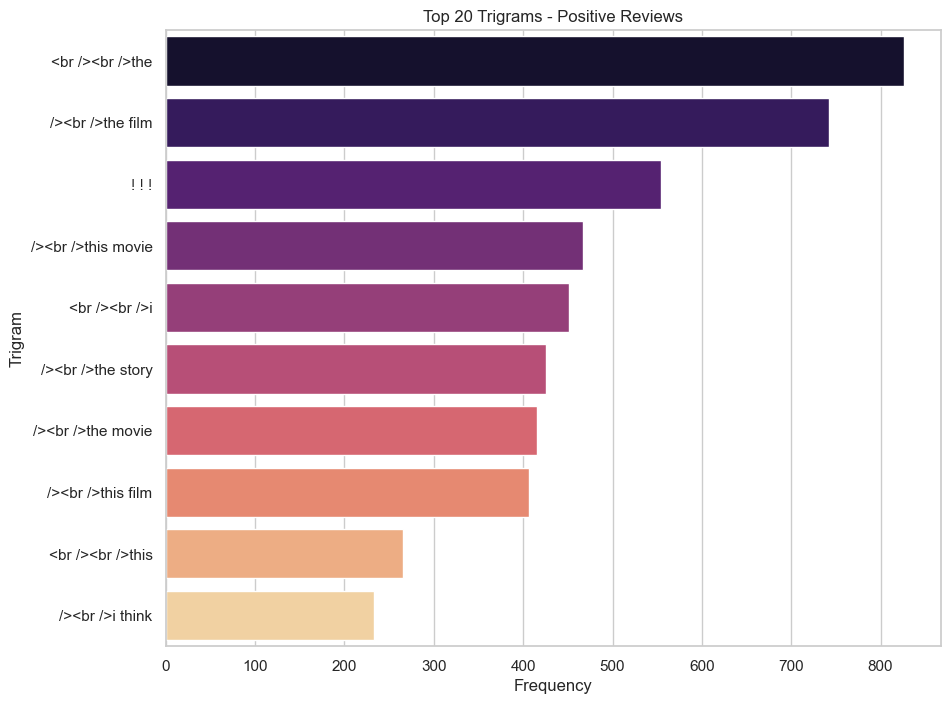

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/2285613859.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="bigram", data=bigrams_neg_df, palette="viridis")


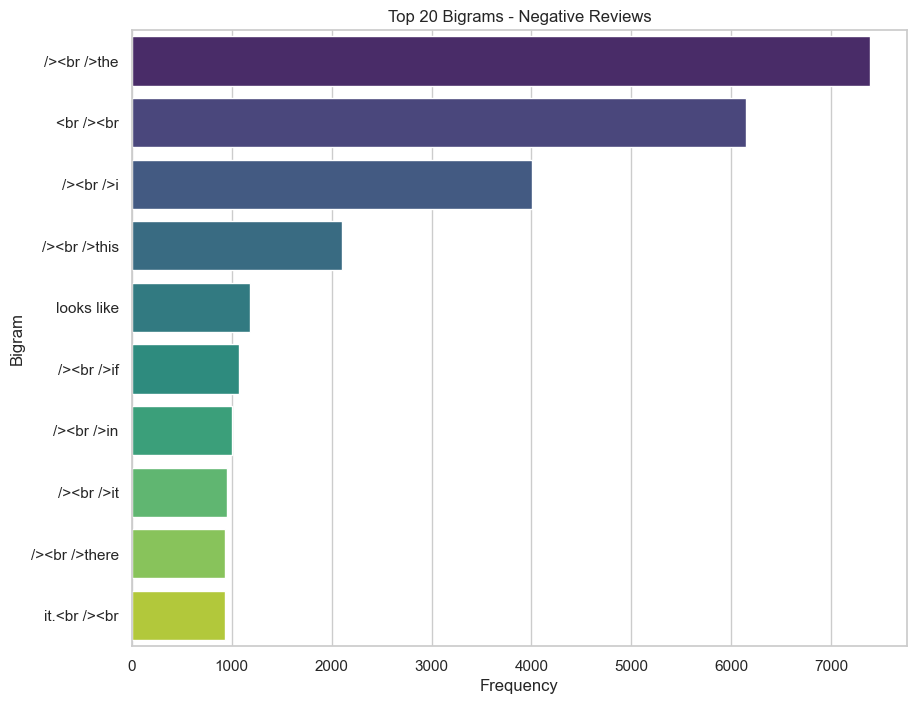

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/2285613859.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="trigram", data=trigrams_neg_df, palette="magma")


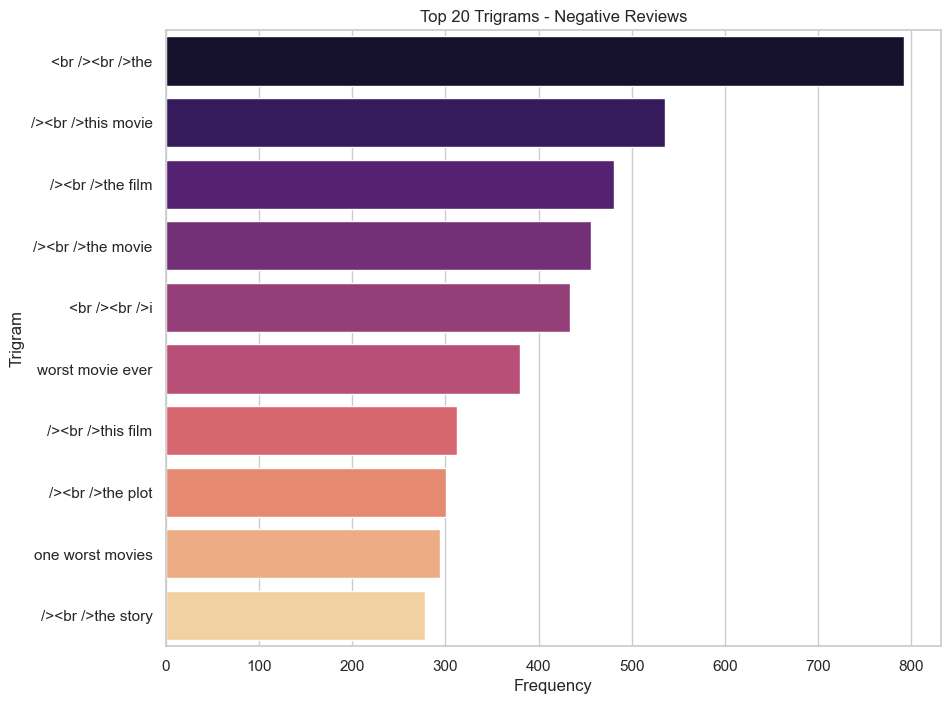

In [9]:
# --- N-Gram Analysis ---
# Compute top bigrams and trigrams for positive reviews
top_bigrams_pos = get_top_ngrams(df_pos['review_text'], 2, top_k=10)
top_trigrams_pos = get_top_ngrams(df_pos['review_text'], 3, top_k=10)

# Convert to DataFrames for plotting
bigrams_pos_df = pd.DataFrame(top_bigrams_pos, columns=["bigram", "count"])
trigrams_pos_df = pd.DataFrame(top_trigrams_pos, columns=["trigram", "count"])

# Plot top bi-grams for positive reviews
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="bigram", data=bigrams_pos_df, palette="viridis")
plt.title("Top 20 Bigrams - Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

# Plot top tri-grams for positive reviews
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="trigram", data=trigrams_pos_df, palette="magma")
plt.title("Top 20 Trigrams - Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

# Compute top bigrams and trigrams for negative reviews
top_bigrams_neg = get_top_ngrams(df_neg['review_text'], 2, top_k=10)
top_trigrams_neg = get_top_ngrams(df_neg['review_text'], 3, top_k=10)

bigrams_neg_df = pd.DataFrame(top_bigrams_neg, columns=["bigram", "count"])
trigrams_neg_df = pd.DataFrame(top_trigrams_neg, columns=["trigram", "count"])

# Plot top bi-grams for negative reviews
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="bigram", data=bigrams_neg_df, palette="viridis")
plt.title("Top 20 Bigrams - Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

# Plot top tri-grams for negative reviews
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="trigram", data=trigrams_neg_df, palette="magma")
plt.title("Top 20 Trigrams - Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

In [10]:
# to be removed
# import re


# def contains_emoji(text):
#     """
#     Checks if a given text contains any emojis.

#     Args:
#         text (str): The input text.

#     Returns:
#         bool: True if any emoji is found, otherwise False.
#     """
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                "]+", flags=re.UNICODE)
#     return bool(emoji_pattern.search(text))


# # Apply the function to each review to create a new column indicating emoji presence
# df['has_emoji'] = df['review_text'].apply(contains_emoji)

# # Count and display the number of reviews containing emojis
# emoji_count = df['has_emoji'].sum()
# print("Number of reviews containing emojis:", emoji_count)

# emoji_reviews = df[df['has_emoji']]
# print("\nReviews with emojis:")
# print(emoji_reviews[['review_text', 'sentiment']])


In [11]:
# --- Stopword Count Analysis ---
# def extract_emojis(text):
#     return [e['emoji'] for e in emoji.emoji_list(text)]


# # Apply to DataFrame to create the 'emojis' column
# df['emojis'] = df['review_text'].apply(extract_emojis)

# # Filter rows that contain at least one emoji
# emoji_reviews = df[df['emojis'].apply(lambda x: len(x) > 0)]
# print(f"Number of reviews containing emojis: {len(emoji_reviews)}")

# # Display a sample
# print(emoji_reviews[['review_text', 'emojis', 'sentiment']].head())

These are not expressive emojis like 😂 or ❤️, but rather Unicode symbols that also fall within emoji ranges. However, we will handle emojis anyway for completeness.


# Data Cleaning

In [12]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from textblob import TextBlob
import emoji
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
import contractions

# Run this for the first time 
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')

In [13]:
# -------------------------------------------
# Lowercasing Text
# -------------------------------------------
def to_lower(text):
    """
    Converts the input text to lowercase.
    """
    return text.lower()

# -------------------------------------------
# Remove HTML Tags
# -------------------------------------------


def remove_html_tags(text):
    """
    Removes HTML tags from the text.
    """
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

# -------------------------------------------
# Remove URLs
# -------------------------------------------


def remove_urls(text):
    """
    Removes URLs from the text using regex.
    """
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

# -------------------------------------------
# Remove Punctuation
# -------------------------------------------


def remove_punctuation(text):
    """Removes punctuation from the text, keeping apostrophes and underscores."""
    # Define punctuation to remove (exclude apostrophe and underscore)
    punctuation_to_remove = string.punctuation.replace("'", "").replace("_", "")
    return text.translate(str.maketrans('', '', punctuation_to_remove))

# -------------------------------------------
# Expand Contractions
# -------------------------------------------

def expand_contractions(text):
    """
    Expands contractions like "can't" → "cannot", "you're" → "you are", etc.
    Optionally, add custom slang expansions (e.g., "gonna" → "going to").
    """
    # Load default contractions
    expanded_text = contractions.fix(text)
    
    # Add custom slang expansions (optional)
    custom_contractions = {
        "gonna": "going to",
        "wanna": "want to",
        "gimme": "give me",
        "ain't": "am not",
        "y'all": "you all"
    }
    for slang, full_form in custom_contractions.items():
        expanded_text = expanded_text.replace(slang, full_form)
    
    return expanded_text

# -------------------------------------------
# Chat Words Conversion
# -------------------------------------------
chat_words = {
    "AFAIK": "as far as i know",
    "AFK": "away from keyboard",
    "ASAP": "as soon as possible",
    "ATK": "at the keyboard",
    "ATM": "at the moment",
    "A3": "anytime anywhere anyplace",
    "BAK": "back at keyboard",
    "BBL": "be back later",
    "BBS": "be back soon",
    "BFN": "bye for now",
    "B4N": "bye for now",
    "BRB": "be right back",
    "BRT": "be right there",
    "BTW": "by the way",
    "B4": "before",
    "CU": "see you",
    "CUL8R": "see you later",
    "CYA": "see you",
    "FAQ": "frequently asked questions",
    "FC": "fingers crossed",
    "FWIW": "for what it's worth",
    "FYI": "for your information",
    "GAL": "get a life",
    "GG": "good game",
    "GN": "good night",
    "GMTA": "great minds think alike",
    "GR8": "great",
    "G9": "genius",
    "IC": "i see",
    "ICQ": "i seek you",
    "ILU": "i love you",
    "IMHO": "in my humble opinion",
    "IMO": "in my opinion",
    "IOW": "in other words",
    "IRL": "in real life",
    "KISS": "keep it simple stupid",
    "LDR": "long distance relationship",
    "LMAO": "laughing my ass off",
    "LOL": "laughing out loud",
    "LTNS": "long time no see",
    "L8R": "later",
    "MTE": "my thoughts exactly",
    "M8": "mate",
    "NRN": "no reply necessary",
    "OIC": "oh i see",
    "PITA": "pain in the ass",
    "PRT": "party",
    "PRW": "parents are watching",
    "QPSA?": "que pasa",
    "ROFL": "rolling on the floor laughing",
    "ROFLOL": "rolling on the floor laughing out loud",
    "ROTFLMAO": "rolling on the floor laughing my ass off",
    "SK8": "skate",
    "STATS": "your sex and age",
    "ASL": "age sex location",
    "THX": "thank you",
    "TTFN": "ta ta for now",
    "TTYL": "talk to you later",
    "U": "you",
    "U2": "you too",
    "U4E": "yours forever",
    "WB": "welcome back",
    "WTF": "what the fuck",
    "WTG": "way to go",
    "WUF": "where are you from",
    "W8": "wait",
    "7K": "sick laugh",
    "TFW": "that feeling when",
    "MFW": "my face when",
    "MRW": "my reaction when",
    "IFYP": "i feel your pain",
    "TNTL": "trying not to laugh",
    "JK": "just kidding",
    "IDC": "i don't care",
    "ILY": "i love you",
    "IMU": "i miss you",
    "ADIH": "another day in hell",
    "ZZZ": "sleeping bored tired",
    "WYWH": "wish you were here",
    "TIME": "tears in my eyes",
    "BAE": "before anyone else",
    "FIMH": "forever in my heart",
    "BSAAW": "big smile and a wink",
    "BWL": "bursting with laughter",
    "BFF": "best friends forever",
    "CSL": "can't stop laughing"
}


def convert_chat_words(text):
    """
    Replaces chat abbreviations with their full forms.
    """
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

# # -------------------------------------------
# # Spelling Correction (tested, not very effective)
# # -------------------------------------------


def correct_spelling(text):
    """
    Uses TextBlob to correct spelling mistakes in the text.
    (Note: This step can be slow on large corpora.)
    """
    blob = TextBlob(text)
    return str(blob.correct())


# -------------------------------------------
# Remove Stopwords
# -------------------------------------------
stop_words = set(stopwords.words('english'))
negation_words = {'no', 'not', 'nor', 'never', 'neither', "don't", "didn't", "won't", "isn't", "aren't", "wasn't", "weren't", "doesn't", "hasn't", "haven't", "hadn't", "can't", "couldn't", "shouldn't", "wouldn't", "mustn't", "mightn't", "shan't"}
stop_words = set(stopwords.words('english')) - negation_words

def remove_stopwords(text):
    """
    Removes common stopwords from the text.
    """
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# -------------------------------------------
# Handling Emojis
# -------------------------------------------


# def remove_emojis(text):
#     """
#     Removes emojis from the text using regex.
#     """
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)


def convert_emojis_to_text(text):
    """
    Converts emojis in the text to their descriptive names.
    """
    return emoji.demojize(text)

# -------------------------------------------
# Tokenization
# -------------------------------------------


def nltk_tokenize(text):
    """
    Tokenizes the text into words using NLTK.
    """
    return word_tokenize(text)


# -------------------------------------------
# Stemming
# -------------------------------------------
stemmer = PorterStemmer()


def stem_text(text):
    """
    Applies Porter Stemming to the text.
    """
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)


# -------------------------------------------
# Lemmatisation (with POS tagging)
# -------------------------------------------
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Converts POS tags from nltk.pos_tag to a format recognized by WordNetLemmatizer.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    """
    Applies WordNet Lemmatisation with POS tagging to the text.
    """
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return " ".join(lemmatized_tokens)


In [14]:
sample_review = """Hey there! <html><body><p>Check out this AMAZING movie review ASAP!</p></body></html> 
Visit https://www.example.com for more info. I can't believe how awesome it was 😍! LOL, the acting was gr8, 
but I ain't too sure about the direction. Also, ceertain moments were confusing... BRB! BTW, did you see that? 
It was on fire 🔥! And remember: I'm not gonna let you down, ya know?"""

print("Sample Text:")
print(sample_review)


Sample Text:
Hey there! <html><body><p>Check out this AMAZING movie review ASAP!</p></body></html> 
Visit https://www.example.com for more info. I can't believe how awesome it was 😍! LOL, the acting was gr8, 
but I ain't too sure about the direction. Also, ceertain moments were confusing... BRB! BTW, did you see that? 
It was on fire 🔥! And remember: I'm not gonna let you down, ya know?


In [15]:
# 1. Lowercasing
lower_review = to_lower(sample_review)
print("\nAfter Lowercasing:")
print(lower_review)

# 2. Removing HTML Tags
html_removed = remove_html_tags(lower_review)
print("\nAfter Removing HTML Tags:")
print(html_removed)

# 3. Removing URLs
urls_removed = remove_urls(html_removed)
print("\nAfter Removing URLs:")
print(urls_removed)

# 4. Removing Punctuation
punct_removed = remove_punctuation(urls_removed)
print("\nAfter Removing Punctuation:")
print(punct_removed)

contractions_expanded = expand_contractions(punct_removed)
print("\nAfter Expanding Contractions:")
print(contractions_expanded)

# 5. Converting Chat Words (if any)
chat_converted = convert_chat_words(contractions_expanded)
print("\nAfter Converting Chat Words:")
print(chat_converted)

# 6. Spelling Correction
# corrected_text = correct_spelling(chat_converted)
# print("\nAfter Spelling Correction:")
# print(corrected_text)

# 7. Removing Stopwords
stopwords_removed = remove_stopwords(chat_converted)
print("\nAfter Removing Stopwords:")
print(stopwords_removed)

# 8. Handling Emojis
# emojis_removed = remove_emojis(stopwords_removed)
# print("\nAfter Removing Emojis:")
# print(emojis_removed)
emojis_converted = convert_emojis_to_text(stopwords_removed)
print("\nAfter Converting Emojis to Text:")
print(emojis_converted)

# 9. Tokenization using NLTK
tokens = word_tokenize(emojis_converted)
print("\nAfter NLTK Tokenization:")
print(tokens)

# 10. Stemming
stemmed_text = stem_text(emojis_converted)
print("\nAfter Stemming:")
print(stemmed_text)

# 11. Lemmatization
lemmatized_text = lemmatize_text(emojis_converted)
print("\nAfter Lemmatization:")
print(lemmatized_text)



After Lowercasing:
hey there! <html><body><p>check out this amazing movie review asap!</p></body></html> 
visit https://www.example.com for more info. i can't believe how awesome it was 😍! lol, the acting was gr8, 
but i ain't too sure about the direction. also, ceertain moments were confusing... brb! btw, did you see that? 
it was on fire 🔥! and remember: i'm not gonna let you down, ya know?

After Removing HTML Tags:
hey there! check out this amazing movie review asap! 
visit https://www.example.com for more info. i can't believe how awesome it was 😍! lol, the acting was gr8, 
but i ain't too sure about the direction. also, ceertain moments were confusing... brb! btw, did you see that? 
it was on fire 🔥! and remember: i'm not gonna let you down, ya know?

After Removing URLs:
hey there! check out this amazing movie review asap! 
visit  for more info. i can't believe how awesome it was 😍! lol, the acting was gr8, 
but i ain't too sure about the direction. also, ceertain moments were 

## Text Preprocessing Explanation

---

### 1. Lowercasing
- Converts all characters to lowercase to ensure uniformity.
- Prevents the same word with different cases (e.g., "Good" and "good") from being treated as different tokens.

---

### 2. Removing HTML Tags
- Eliminates HTML elements (such as `<div>`, `<br>`, etc.) that may be present if the data comes from web pages.
- HTML tags do not add any useful semantic information and can introduce noise.

---

### 3. Removing URLs
- Strips out URLs that are typically irrelevant for meaning.
- Helps to reduce noise in the data, especially if the text is scraped from the web.

---

### 4. Removing Punctuation
- Removes punctuation to simplify the text and assist with tokenisation.
- Reduces noise and helps with tasks like matching words and reducing vocabulary size.
- **Note**: In some cases, such as sentiment analysis, punctuation can carry meaning, so consider whether you want to remove it.

---

### 5. Expanding Contractions
- Expands shortened phrases like "can't" to "cannot", "you're" to "you are", etc., using a contractions library and custom slang mapping.
- Helps to unify different forms of similar expressions and improve downstream model understanding.
- Prevents loss of negation meaning (e.g., “don’t” → “do not”).
- Helps with tokenisation and lemmatisation.

---

### 6. Converting Chat Words
- Replaces informal abbreviations (e.g., "LOL", "BRB") with their full forms to standardise the language.
- Particularly useful for social media text, reviews, or chat messages where slang is common.

---

### 7. Spelling Correction (Not Included)
- Uses tools to fix typographical errors, which can be useful if the data is very noisy.
- Based on the experimentation, it introduces incorrect corrections, especially with proper nouns or slang. Hence, we are skipping this step.

---

### 8. Removing Stopwords
- Eliminates common words (e.g., "the", "is", "and") that may not add value for tasks like topic modelling or similarity comparisons.
- Helps reduce the dimensionality of the data.
- **Note**: For deep learning models, it is sometimes beneficial to retain stopwords.

---

### 9. Handling Emojis
- **Removing Emojis**: Clears out emojis which can be considered non-verbal noise if not needed.
- **Converting Emojis to Text**: Translates emojis into descriptive text (e.g., "face with tears of joy") to retain their sentiment value.
- It is generally better to convert emojis rather than remove them, especially for sentiment or emotion analysis.

---

### 10. Handling Negations
- Negation words (e.g., “not”, “no”, “never”, “don’t”) are critical for understanding the sentiment and meaning of a sentence.
- We ensure negations are preserved by:
  - **Keeping them out of the stopword list**.
  - **Preserving contractions** (e.g., “don’t”, “isn’t”) by retaining apostrophes when removing punctuation.
  - (Optional) **Marking negated words** that follow a negation cue (e.g., “not good” → “not_good”) to help models capture negation scope.
- Proper handling of negations prevents incorrect sentiment or meaning inference (e.g., interpreting “not bad” as “bad”).

---

### 11. Tokenisation
- Splits the text into individual words (tokens), which are the basic units for NLP processing.
- Essential for any further analysis or feature extraction (such as TF-IDF or embeddings).

---

### 12. Stemming (Not Included)
- Reduces words to their root form, which reduces vocabulary size.
- Faster than lemmatisation but more aggressive and less accurate (e.g., “studies” → “studi”). Hence, we are using lemmatisation.

---

### 13. Lemmatisation
- Converts words to their base or dictionary form using linguistic rules (e.g., "running" becomes "run").
- More accurate than stemming and preserves valid words.
- Preferred over stemming for most NLP tasks.

---

## Summary of Text Preprocessing Pipeline

1. Lowercasing  
2. Removing HTML Tags  
3. Removing URLs  
4. Handling Emojis  
5. Removing Punctuation (retain if necessary for sentiment analysis)  
6. Expanding Contractions
7. Converting Chat Words  
8. Removing Stopwords (retain if necessary for deep learning models)  
9. **Handling Negations**  
10. Lemmatisation  
11. Tokenisation  

### Skip:
- Spelling Correction  
- Stemming  

This pipeline helps to clean and normalise the text while preserving meaningful information for analysis.

In [16]:
def process_text(text):
    """
    Applies a sequence of preprocessing steps to clean the input text.
    Skips spelling correction and stemming.
    """
    text = to_lower(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = convert_emojis_to_text(text)
    text = remove_punctuation(text)
    text = expand_contractions(text)
    text = convert_chat_words(text)
    text = remove_stopwords(text)
    return text

df['cleaned_text'] = df['review_text'].apply(process_text)

print("Sample Processed Reviews:")
print(df[['review_text', 'cleaned_text']].head())

Sample Processed Reviews:
                                         review_text  \
0  I can't say much about this film. I think it s...   
1  After the initial shock of realizing the guts ...   
2  Seven Ups has been compared to Bullitt for the...   
3  There is a scene in Dan in Real Life where the...   
4  I wouldn't say this is a *bad* movie. Unfortun...   

                                        cleaned_text  
0  cannot say much film think speaks current rati...  
1  initial shock realizing guts mr branagh film l...  
2  seven ups compared bullitt chase scene not com...  
3  scene dan real life family competing see sex f...  
4  would not say bad movie unfortunately get feel...  


# Re-run EDA (Word Cloud and N-Grams) on Cleaned Data

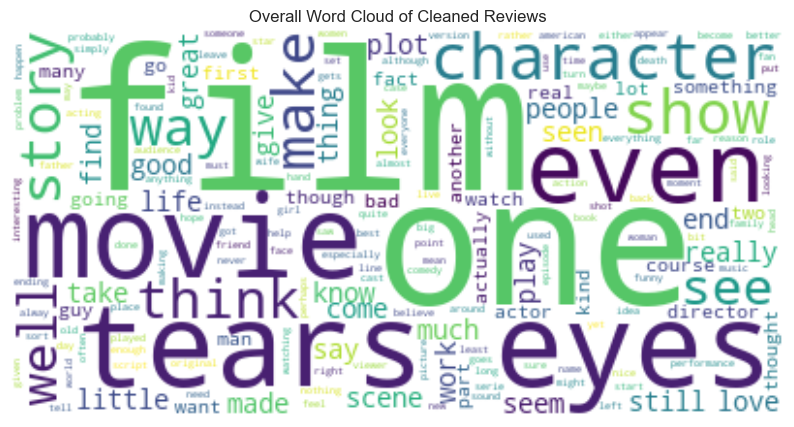

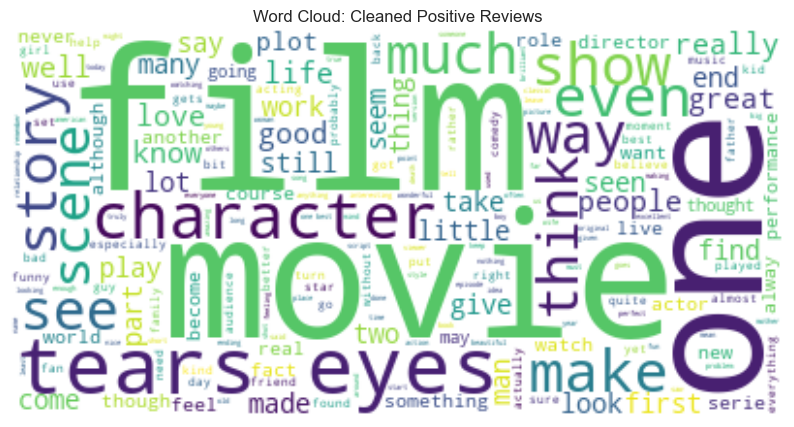

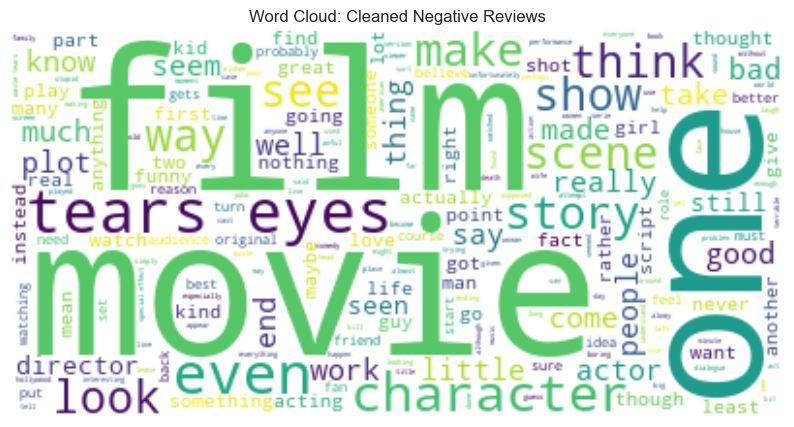

In [17]:
df_pos_clean = df[df['sentiment'] == 'positive']
df_neg_clean = df[df['sentiment'] == 'negative']

display_wordcloud(df['cleaned_text'], "Overall Word Cloud of Cleaned Reviews")
display_wordcloud(df_pos_clean['cleaned_text'], "Word Cloud: Cleaned Positive Reviews")
display_wordcloud(df_neg_clean['cleaned_text'], "Word Cloud: Cleaned Negative Reviews")

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/1772639181.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="bigram", data=bigrams_pos_clean_df, palette="viridis")


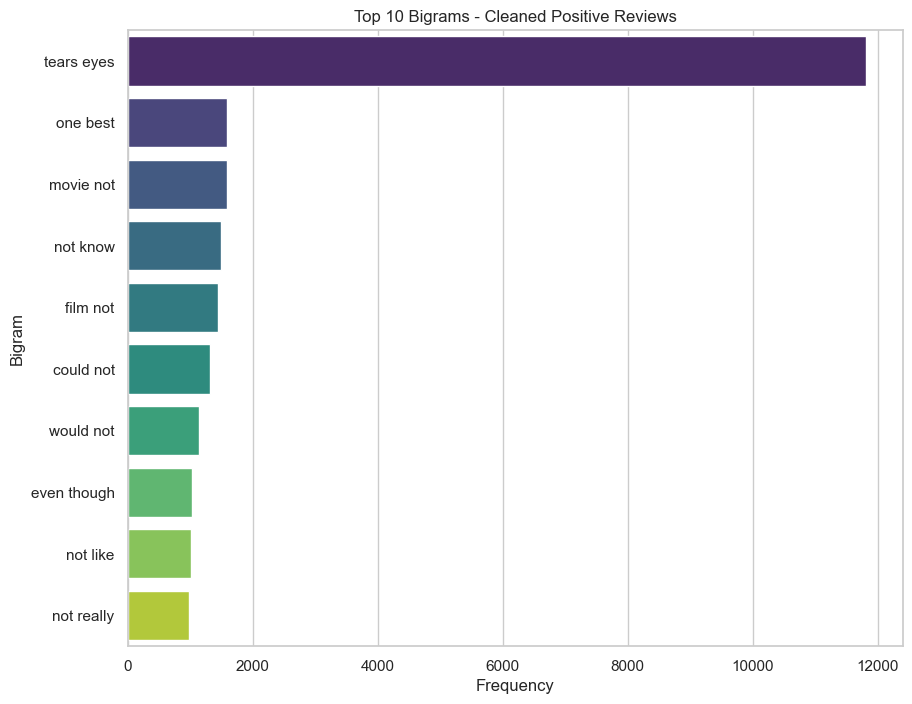

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/1772639181.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="trigram", data=trigrams_pos_clean_df, palette="magma")


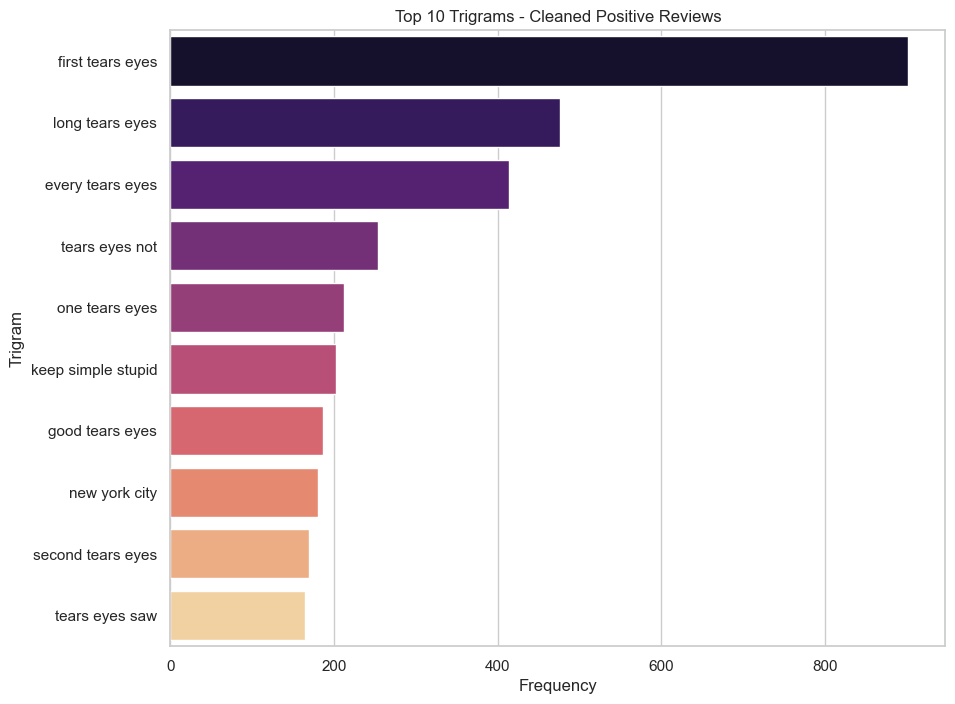

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/1772639181.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="bigram", data=bigrams_neg_clean_df, palette="viridis")


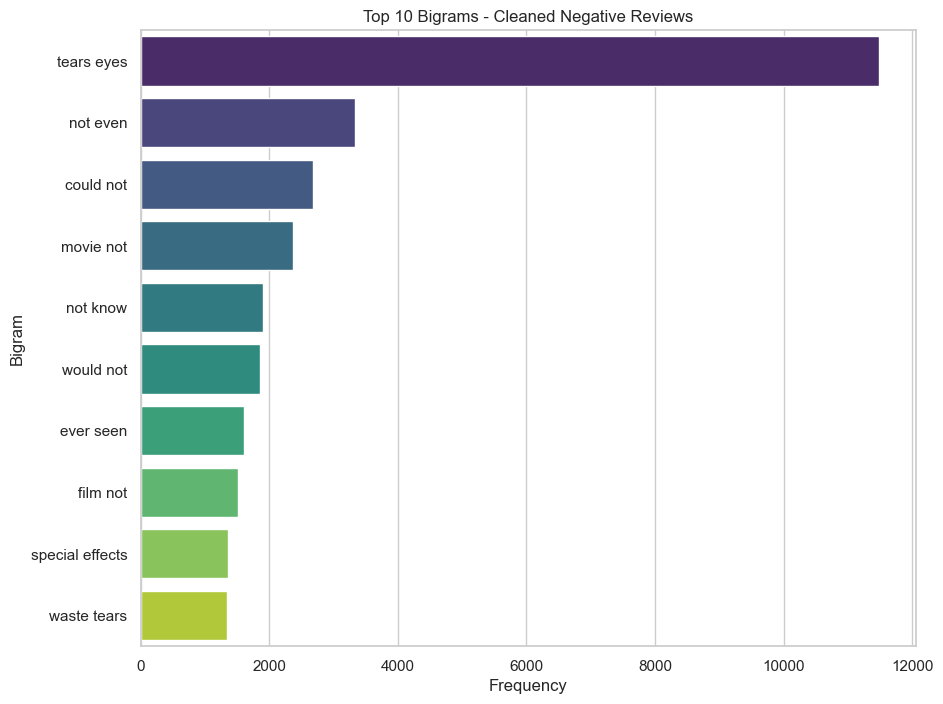

/var/folders/8y/g9408__d703c4gbgs7qsbkyh0000gn/T/ipykernel_76106/1772639181.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="trigram", data=trigrams_neg_clean_df, palette="magma")


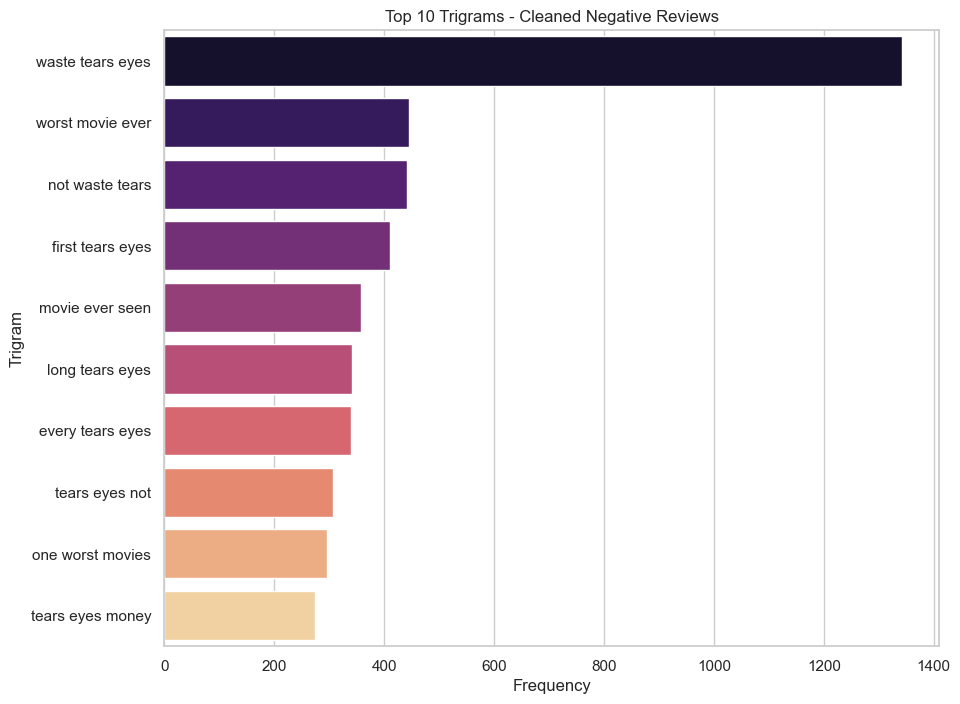

In [19]:
# --- N-Gram Analysis on Cleaned Data ---
# Positive reviews
top_bigrams_pos_clean = get_top_ngrams(df_pos_clean['cleaned_text'], 2, top_k=10)
top_trigrams_pos_clean = get_top_ngrams(df_pos_clean['cleaned_text'], 3, top_k=10)

# Negative reviews
top_bigrams_neg_clean = get_top_ngrams(df_neg_clean['cleaned_text'], 2, top_k=10)
top_trigrams_neg_clean = get_top_ngrams(df_neg_clean['cleaned_text'], 3, top_k=10)

bigrams_pos_clean_df = pd.DataFrame(top_bigrams_pos_clean, columns=["bigram", "count"])
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="bigram", data=bigrams_pos_clean_df, palette="viridis")
plt.title("Top 10 Bigrams - Cleaned Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

trigrams_pos_clean_df = pd.DataFrame(top_trigrams_pos_clean, columns=["trigram", "count"])
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="trigram", data=trigrams_pos_clean_df, palette="magma")
plt.title("Top 10 Trigrams - Cleaned Positive Reviews")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

bigrams_neg_clean_df = pd.DataFrame(top_bigrams_neg_clean, columns=["bigram", "count"])
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="bigram", data=bigrams_neg_clean_df, palette="viridis")
plt.title("Top 10 Bigrams - Cleaned Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

trigrams_neg_clean_df = pd.DataFrame(top_trigrams_neg_clean, columns=["trigram", "count"])
plt.figure(figsize=(10,8))
sns.barplot(x="count", y="trigram", data=trigrams_neg_clean_df, palette="magma")
plt.title("Top 10 Trigrams - Cleaned Negative Reviews") 
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

# Tokenisation and Lemmatisation

In [20]:
# Apply lemmatization to the cleaned text
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

# Inspect results
print("\nSample preprocessed and lemmatized text:")
print(df[['cleaned_text', 'lemmatized_text']].head(3))


Sample preprocessed and lemmatized text:
                                        cleaned_text  \
0  cannot say much film think speaks current rati...   
1  initial shock realizing guts mr branagh film l...   
2  seven ups compared bullitt chase scene not com...   

                                     lemmatized_text  
0  can not say much film think speaks current rat...  
1  initial shock realize gut mr branagh film lite...  
2  seven ups compare bullitt chase scene not come...  


# Train-Test Split

In [21]:
# Convert sentiment labels to binary (positive = 1, negative = 0)
df['sentiment_binary'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Check the mapping by displaying the first few rows
print(df[['sentiment', 'sentiment_binary']].head())

# Now, prepare your features and labels
# Here, we're using the lemmatized text as our feature
X = df['lemmatized_text']
y = df['sentiment_binary']

from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and testing (20%) sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

  sentiment  sentiment_binary
0  negative                 0
1  positive                 1
2  positive                 1
3  positive                 1
4  negative                 0
Training set size: 40000
Test set size: 10000


In [22]:
# Combine the training features and labels into a DataFrame
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})
test_df = pd.DataFrame({'text': X_test, 'sentiment': y_test})

# Save the DataFrames as CSV files
train_df.to_csv('/data/train_set.csv', index=False)
test_df.to_csv('data/test_set.csv', index=False)

print("Training and test sets have been saved successfully!")

Training and test sets have been saved successfully!
